# Adult Income Predictor Report

- DSCI 522 - Workflows
- MDS 2024-2025
- Group 24
- Members: Michael Suriawan, Francisco Ramirez, Tingting Chen, Quanhua Huang

## Summary

This report presents the application of a K-Nearest Neighbors (KNN) Classifier to predict an individual's annual income based on selected categorical socioeconomic features from the Adult dataset. The dataset, sourced from the 1994 U.S. Census Bureau, contains 48,842 instances and features such as age, education, occupation, and marital status. The model achieved an accuracy of approximately 80%, with a tendency to predict more individuals with incomes below $50K compared to those above. This result emphasizes the importance of socioeconomic factors in determining income levels. Further investigation into individual feature contributions and the inclusion of numerical variables like age and hours-per-week could enhance prediction performance.

## Introduction

The Adult dataset, originally curated from the 1994 U.S. Census Bureau database, is a well-known benchmark dataset in machine learning. Its primary objective is to predict whether an individual earns more or less than $50,000 annually based on various demographic and socio-economic attributes. With 48,842 instances and 14 features, the dataset encompasses a mix of categorical and continuous variables, making it a rich resource for classification tasks and exploratory data analysis.

The model described in this notebook, looks to use a trained "Nearest Neighbors" Classifier to use different socioeconomic features to predict the range of the individual's income. The features in the data set include characteristics such as age, education level, marital status, occupation, among others.

The model looks to predict whether or not an individual's income exceeds $50K/yr based on the selected categorical socioeconomic features. For simplicity, only selected categorical features from the original data set. These features are specifically encoded based on their content prior to training the kNN classifier used for predictions. 

**Note**: The original data set's reference information can be found at the end of this document. 

# Setup

In [1]:
import os
import requests
import zipfile
import json
import logging
import pandas as pd
import pandera as pa
import altair as alt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay 
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation
from deepchecks.tabular.checks.data_integrity import FeatureFeatureCorrelation
from deepchecks.tabular.checks import ClassImbalance
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Download and Extract Dataset

In [2]:
# download data as zip and extract
url = "https://archive.ics.uci.edu/static/public/2/adult.zip"

request = requests.get(url)
os.makedirs("../data/raw", exist_ok=True)

with open("../data/raw/adult.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("../data/raw/adult.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

# Data Validation 1: Raw Data File Format

In [3]:
file_path = "../data/raw/adult.data"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Unable to find raw file in {file_path}. Please see the download step to investigate.")
if not file_path.endswith('.data'):
    raise ValueError(f"{file_path} is not a DATA file. Please see the download step to investigate.")

print("Data Validation 1 passed: Data File Format has been checked and verified!")

Data Validation 1 passed: Data File Format has been checked and verified!


# Load and Preview the Dataset

The following cell loads and displays the original data set. 

It also adds names to the columns aligned to the description from the data set location in the UC Irvine Machine Learning Repository.

In [4]:
data_adult = pd.read_csv("../data/raw/adult.data", names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data Validation 2: DataFrame Checks

To ensure that the analysis is not influenced by erroneous data, the following cells aim to validate the quality of the loaded data before we perform such analyses. 

In this section, the loaded data will be validated for the following characteristics:

- Correct column names
- No empty observations
- Missingness not beyond expected threshold
- Correct data types in each column
- No duplicate observations
- No outlier or anomalous values
- Correct category levels (i.e., no string mismatches or single values)

Note that a log file called "validation_errors.log" will be created in this notebook location documenting the errors found by the validation process.

In [5]:
# Configure logging
logging.basicConfig(
    filename="validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

Validation checks below:

In [6]:
# Define the schema
schema = pa.DataFrameSchema(
    {
        "age": pa.Column(int, pa.Check.between(0, 120), nullable=True),
        "age": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'age' column.")),
        
        "workclass": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"]), error="Invalid value for 'workclass'."), nullable=True),
        "workclass": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'workclass' column.")),
        
        "fnlwgt": pa.Column(int, nullable=True),
        "fnlwgt": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'fnlwgt' column.")),
        
        "education": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool"]), error="Invalid value for 'education'."), nullable=True),
        "education": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'education' column.")),
        
        "education-num": pa.Column(int, pa.Check.between(0, 50), nullable=True),
        "education-num": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'education-num' column.")),
        
        "marital-status": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]), error="Invalid value for 'marital-status'."), nullable=True),
        "marital-status": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'marital-status' column.")),
        
        "occupation": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"]), error="Invalid value for 'occupation'."), nullable=True),
        "occupation": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'occupation' column.")),
        
        "relationship": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried"]), error="Invalid value for 'relationship'."), nullable=True),
        "relationship": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'relationship' column.")),
        
        "race": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]), error="Invalid value for 'race'."), nullable=True),
        "race": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'race' column.")),
        
        "sex": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(['Female', 'Male']), error="Invalid value for 'sex'."), nullable=True),
        "sex": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'sex' column.")),
        
        "capital-gain": pa.Column(int, nullable=True),
        "capital-gain": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'capital-gain' column.")),
        
        "capital-loss": pa.Column(int, nullable=True),
        "capital-loss": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'capital-loss' column.")),
        
        "hours-per-week": pa.Column(int, pa.Check.between(0, 120), nullable=True),
        "hours-per-week": pa.Column(int, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'hours-per-week' column.")),
        
        "native-country": pa.Column(str, pa.Check(lambda s: s.str.strip().isin(["United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"]), error="Invalid value for 'native-country'."), nullable=True),
        "native-country": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'native-country' column.")),
        
        "income": pa.Column(str, pa.Check(lambda s: s.str.strip().isin([">50K", "<=50K"]), error="Invalid value for 'income'."), nullable=True),
        "income": pa.Column(str, pa.Check(lambda s: s.isna().mean() <= 0.05, element_wise=False, error="Too many null values in 'income' column."))
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
    ],
    drop_invalid_rows=False,
)

The following cell, will have all the errors found in the validation process removed from the dataframe for following steps in the analysis, as well as populating the "validation_errors.log" file.

In [7]:
# Initialize error cases DataFrame
error_cases = pd.DataFrame()
data = data_adult.copy()

# Validate data and handle errors
try:
    validated_data = schema.validate(data, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    # Convert the error message to a JSON string
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows based on the error cases
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    validated_data = (
        data.drop(index=invalid_indices)
        .reset_index(drop=True)
        .drop_duplicates()
        .dropna(how="all")
    )
else:
    validated_data = data

data_adult = validated_data

print("Data Validation 2 passed: Data Validation performed on Dataframe!")

Data Validation 2 passed: Data Validation performed on Dataframe!


This is the resulting data set following validation. As it can be seen, a few rows were removed from the original data set given that they did not comply with the validation rules defined.

In [8]:
data_adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# EDA Analysis
## Data Summary
Below is the summary of our dataset which contains numerical and categorical variables

In [9]:
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [10]:
data_adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Visualization of Dataset

In [11]:
alt.Chart(data_adult, title = "Income for different marital status").mark_bar(opacity = 0.75).encode(
    alt.Y('marital-status').title("Marital Status"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

In [12]:
alt.Chart(data_adult, title = "Income for different relationship").mark_bar(opacity = 0.75).encode(
    alt.Y('relationship').title("Relationships"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

In [13]:
alt.Chart(data_adult, title = "Income for different occupation").mark_bar(opacity = 0.75).encode(
    alt.Y('occupation').title("Occupations"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

In [14]:
alt.Chart(data_adult, title = "Income for different workclass").mark_bar(opacity = 0.75).encode(
    alt.Y('workclass').title("Workclass"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

In [15]:
alt.Chart(data_adult, title = "Income for different race").mark_bar(opacity = 0.75).encode(
    alt.Y('race').title("Race"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

In [16]:
alt.Chart(data_adult, title = "Income for different sex").mark_bar(opacity = 0.75).encode(
    alt.Y('sex').title("Sex"),
    alt.X('count()').stack(False),
    alt.Color('income')
).properties(
    height=200,
    width=300
)

alt.Chart(...)

## Train/Test Split

The following cell separates the data set into train and test sets for purposes of training the classifier model. 

It uses an 80/20 data split for training and test.

It also defines the target colums, which will be the income range (Column = income)

In [17]:
train_df, test_df = train_test_split(data_adult, test_size=0.20, random_state=123)
X_train, y_train = (
    train_df.drop(columns=['income']),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=['income']),
    test_df["income"],
)

## Data Validation 3: Target / Response Distribution

The following validation will be performed:
- Target/response variable follows expected distribution

In [18]:
adult_train_ds = Dataset(train_df, label="income", cat_features=[])

In [19]:
train_df["income"].value_counts()

income
 <=50K    19802
 >50K      6227
Name: count, dtype: int64

In [20]:
check_dist = ClassImbalance().add_condition_class_ratio_less_than(0.4).run(adult_train_ds)
if not check_dist.passed_conditions():
    raise ValueError("Error message here")

print("Data Validation 3 passed: The target has at least a 40%/60% split!")

Data Validation 3 passed: The target has at least a 40%/60% split!


## Data Validation 4: Deep Checks Validation
The following deepchecks validations will be performed:
- No anomalous correlations between target/response variable and features/explanatory variables
- No anomalous correlations between features/explanatory variables

In [21]:
check_feat_label_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_label_corr_result = check_feat_label_corr.run(dataset = adult_train_ds)

if not check_feat_label_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(0.8, 3)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset = adult_train_ds)

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-Feature correlation exceeds the maximum acceptable threshold.")

print("Data Validation 4 passed: Deep checks validation has been performed successfully!")

Data Validation 4 passed: Deep checks validation has been performed successfully!


## Column Selection

The following cell describes which columns were selected to train the classifier model.

For simplicity, the model is focused on using categorical variables available in the data set.

In [22]:
categorical_features = ["marital-status", "relationship", "occupation", "workclass", "race"]
binary_features = ["sex"]
drop_features = ["age", "fnlwgt", "education", "education-num", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

## Preprocessing

The following cell uses One Hot Encoder to encode categorical features, as well as using a Simple Imputer to deal with missing data in the data set.

Additionally, it creates a Column Transformer describing the treatment that each column will get during the encoding process.

In [23]:
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(   
    (binary_transformer, binary_features),    
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

## Model Fit

A pipeline is created that describes the preprocessing and KNN flow that will be used to train the model with "fit". Immediately after, the model's performance score is displayed based on training data.

In [24]:
model = KNeighborsClassifier()
pipe = make_pipeline(preprocessor, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['sex']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['marital-status',
                                                   'relationship', 'occupation',
                                                   'workclass', 'race']),
                                                 ('drop', 'drop',
                                                  ['age', 'fnlwgt', 'education',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'native-country'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [25]:
pipe.score(X_train, y_train)

0.7979177071727689

## Model Test Score and Prediction

Finally, the model is scored on the unseen examples. 

Additionally, it displays the hard predictions the model does on the test data.

In [26]:
test_score = pipe.score(X_test, y_test)
test_score

0.7965580823601721

## Visualization of the prediction result


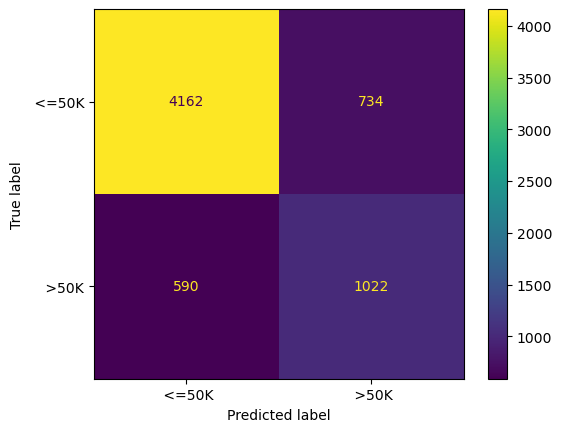

In [27]:
cm = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_test,
    y_test,
    values_format="d"
)

cm

# Discussion

The KNN model described in this notebook is able to predict the income of an individual based on the described categorical features with an accuracy of ~80% as seen in the training and test scores. 

It was expected that selected categorical features would influence the income range for individuals, particularly those related to occupation and education level. 

With above histograms, we notice that our KNN model predicts more individuals to have income that is less than 50K and predict less individuals to have more than 50K income, comparint to the actual results.

These findings support the notion that specific socioeconomic characteristics of individuals have a direct influence on the individual's income level.

However, this analysis opens the question on how each individual feature affects the model. Therefore, further deep-dive could better inform if all features have a significant influence on the model's ability to predict accurately. Additional numerical features, such as age and hours-per-week are likely to improve the model training process and could be evaluated as well.

# References

- Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.
- Kolhatkar, V. UBC Master of Data Science program, 2024-25, DSCI 571 Supervised Learning I. 
- Ostblom, J. UBC Master of Data Science program, 2024-25, DSCI 573 Feature and Model Selection.
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.